<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [90]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [91]:
auth.authenticate_user()

In [92]:
# !gcloud config set project {'hackathon-352519'}

In [93]:
filename = "train-data_all-train-events.zip"

In [94]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [95]:
!gsutil del /tmp/$filename

CommandException: "rm" command does not support "file://" URLs. Did you mean to use a gs:// URL?


In [96]:
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    prevLoco = currentLoco
                            

1000   19:15:30
2000   19:15:44
3000   19:15:51
4000   19:15:58
5000   19:16:02
6000   19:16:06
7000   19:16:14
8000   19:16:19
9000   19:16:22
10000   19:16:29


In [97]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [98]:
del trains

In [99]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 0
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        10054 non-null  object 
 1   maximumTrainSpeed                                                          10053 non-null  float64
 2   loadedCarCount                                                             10053 non-null  float64
 3   emptyCarCount                                                              10053 non-null  float64
 4   trainLength                                                                10053 non-null  float64
 5   trailingTonnage                                                            10053 non-null  float64
 6   positionHistoryList                                       

In [100]:
dfTrainsLearn = dfTrainsAll
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [101]:
def getWorkLocations(dfTrainsLocation):
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [102]:
#getWorkLocations(dfTrainsLearn.iloc[301])

In [103]:
#dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]

In [104]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [105]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '258.40,202.20', '202.20,258.40', '202.20,258.40,321.50', '202.92,202.20', '225.10,202.20', '240.90,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [106]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [107]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [134]:
dfTrainsLearnActuals

0               positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-04-21T23:33:08Z       -10                             106   
1  2022-04-21T23:35:08Z       -10                             106   
2  2022-04-21T23:37:08Z       -10                             106   
3  2022-04-21T23:39:08Z        -8                             106   
4  2022-04-21T23:41:08Z        -8                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                  WEST MAIN                                  766.5422  
1             WEST MAIN-MAIN       ...
0               positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-04-21T23:34:11Z       -10                             106   
1  2022-04-21T23:36:11Z       -10                             106   
2  2022-04-21T23:38:11Z        -9                             106   
3  2022-04-21T23:40:11Z        -8                             106   
4  2022-04-21T23:42:11Z        -9            

In [136]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,766.9304,"[{'positionTime': '2022-04-21T23:31:08Z', 'speedMPH': -12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.9304}}}, {'positionTime': '2022-04-21T23:33:08Z', 'speedMPH': -19, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.4076}}}, {'positionTime': '2022-04-21T23:35:08Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.6378}}}, {'positionTime': '2022-04-21T23:37:08Z', 'speedMPH': -30, 'milepostLocation': {'su..."
1,766.7188,"[{'positionTime': '2022-04-21T23:32:11Z', 'speedMPH': -11, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.7188}}}, {'positionTime': '2022-04-21T23:34:11Z', 'speedMPH': -19, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.2204}}}, {'positionTime': '2022-04-21T23:36:11Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.4652}}}, {'positionTime': '2022-04-21T23:38:11Z', 'speedMPH': -30, 'milepostLocation': {'su..."
2,766.5653,"[{'positionTime': '2022-04-21T23:33:00Z', 'speedMPH': -10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.5653}}}, {'positionTime': '2022-04-21T23:35:00Z', 'speedMPH': -18, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.0905}}}, {'positionTime': '2022-04-21T23:37:00Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.349}}}, {'positionTime': '2022-04-21T23:39:00Z', 'speedMPH': -30, 'milepostLocation': {'sub..."
3,766.4352,"[{'positionTime': '2022-04-21T23:33:45Z', 'speedMPH': -10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.4352}}}, {'positionTime': '2022-04-21T23:35:45Z', 'speedMPH': -18, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.9604}}}, {'positionTime': '2022-04-21T23:37:45Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.2188}}}, {'positionTime': '2022-04-21T23:39:45Z', 'speedMPH': -30, 'milepostLocation': {'su..."
4,766.3228,"[{'positionTime': '2022-04-21T23:34:24Z', 'speedMPH': -10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 766.3228}}}, {'positionTime': '2022-04-21T23:36:24Z', 'speedMPH': -18, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.848}}}, {'positionTime': '2022-04-21T23:38:24Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'WEST MAIN', 'milepost': {'milepostNumber': 765.1065}}}, {'positionTime': '2022-04-21T23:40:24Z', 'speedMPH': -30, 'milepostLocation': {'sub..."
...,...,...
10049,247.7004,[]
10050,247.9916,[]
10051,248.2571,[]
10052,248.4556,[]


In [109]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [233]:
def findNextMilepost(trainsEntry, actualsEntry):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost+1]
  if (len(value) > 0) :
    return value.min()
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost-1]
  if (len(value) > 0):
    return value.max()
  return []

In [237]:
def findNextSpeed(trainsEntry, actualsEntry):
  nextActual = findNextMilepost(trainsEntry, actualsEntry)
  if (len(nextActual) > 0):
    amt = (abs(nextActual['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    return amt;
  return None

In [263]:
idx = 300
print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
print(dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print(nextActual)
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print(findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))
else:
  print('na')

ZG2BRB
65
positionTime                                2022-04-10T04:39:12Z
speedMPH                                                      39
milepostLocation.subdivisionId                               106
milepostLocation.trackName                                  MT 1
milepostLocation.milepost.milepostNumber               287.96017
dtype: object
na


In [227]:
dfTrainsLearn['nextSpeed'] = np.NaN
dfTrainsLearn['nextBeop'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextSpeed = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      nextBeop = findNextSpeed(trainsEntry, beopDT)
      if (nextBeop != None):
        dfTrainsLearn.at[i,'nextBeop'] = nextSpeed
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [228]:
dfTrainsLearn['nextSpeed'].unique()

array([ -4.,  -3.,  -2.,  -1.,  nan, -56., -58., -55., -43., -29., -34.,   0., -12., -22., -28., -27., -65., -68., -70., -67., -64., -71., -69., -62., -59., -61., -66., -48., -50., -53., -60., -52.,
       -47., -46., -38., -37., -51.,  26.,  24.,  31.,  36.,  37.,  16.,   4.,  13.,  -6.,   1.,  -7., -16.,  -8., -24.,  -9., -14., -17., -11., -21., -25., -26., -23., -31., -32., -33., -30., -13.,
        -5., -18., -15., -20., -10., -19.,  11., -36., -40., -41., -45., -44., -57., -49., -39., -63., -54.,  29.,  39.,  21.,  19.,  12., -42., -35.,  27.,  22.,  18.,  30.,  23.,  28.,   3.,   7.,
         8.,   6.,   2.,  10.,   5.,  20.,  25.,   9.,  32.,  14.,  17.,  33.,  15.,  38.,  35.,  34.])

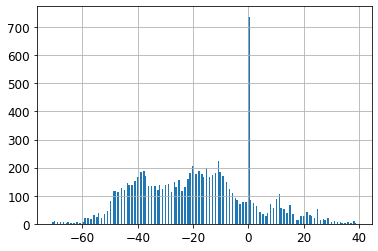

In [229]:
dfTrainsLearn['nextSpeed'].hist(bins=200)

In [230]:
dfTrainsLearn['nextBeop'].unique()

array([ -4.,  -3.,  -2.,  -1.,  nan, -12., -11.,  -9., -13., -14., -15., -16., -17., -18., -19., -20., -21., -27., -34., -35., -33., -31., -30., -29., -25., -23., -26., -37., -46., -47., -41., -39.,
       -36., -38., -40., -44., -42., -52., -54., -28., -45., -49., -48., -22.,  -7., -43.,   4.,   0.,   2.,   7.,   1.,  -8., -10., -24., -32.,   3.,   9.,   8.,  -6.,  -5.,   5.,   6.,  15., -60.,
       -50., -53., -59., -58., -57., -56., -55.,  16.,  12., -51.,  19.,  14.,  11.,  10.,  13.])

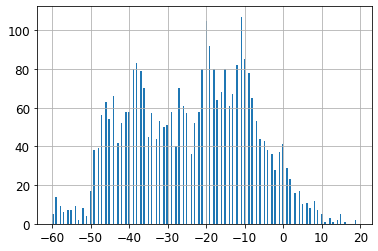

In [231]:
dfTrainsLearn['nextBeop'].hist(bins=200)

Drop some values we are not using at the moment not needed

In [26]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            'lastReportedPosition.nextSignalState.previousSignalState', 
                                            'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [27]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
1,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
2,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
3,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
4,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
...,...,...,...,...,...,...,...,...,...
10049,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
10050,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
10051,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
10052,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09


In [28]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(10054, 51)
(10054,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10054 entries, 0 to 10053
Data columns (total 51 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   ptcLeadLocomotiveId                                                        10054 non-null  object        
 1   maximumTrainSpeed                                                          10053 non-null  float64       
 2   loadedCarCount                                                             10053 non-null  float64       
 3   emptyCarCount                                                              10053 non-null  float64       
 4   trainLength                                                                10053 non-null  float64       
 5   trailingTonnage                                                            10053 non-nul

# Use Decision Tree to predict speed in 1 mile

In [29]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [30]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
90     124
91     271
92      79
93     106
95     109
      ... 
121     45
122    247
123    214
124    237
125    150
Name: lastReportedPosition.positionTimeDayofyear, Length: 33, dtype: int64


In [31]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 121 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [32]:
dep_var = 'nextSpeed'

In [33]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [34]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [35]:
len(to.train),len(to.valid)

(9161, 893)

In [36]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.ownershipCode,aotuTrainData.eventCode,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,maximumTrainSpeed_na,loadedCarCount_na,emptyCarCount_na,trainLength_na,trailingTonnage_na,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.precedingSignalState.previousSignalState_na,lastReportedPosition.precedingSignalState.signalState_na,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.nextSignalState.signalState_na,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-12,766.930420,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-4
1,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-11,766.718811,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-3
2,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.565308,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-2
3,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.435181,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-1
4,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.322815,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-1
5,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,#na#,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0

In [37]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [38]:
to = fastai.load_pickle('/tmp/to.pkl')

In [39]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [40]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

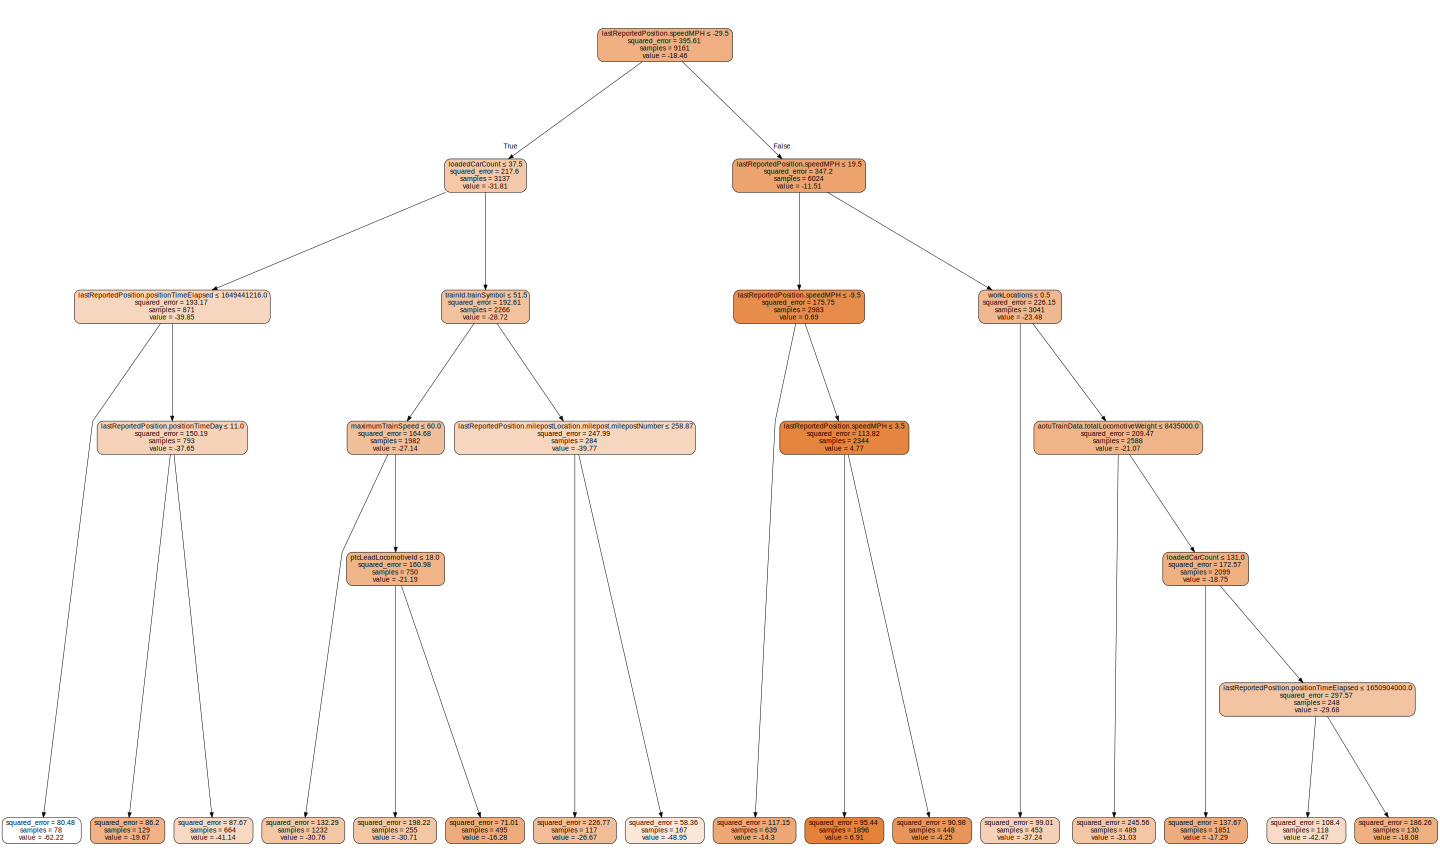

In [41]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [42]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [43]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [44]:
m_rmse(m, xs, y)

4.059706

In [45]:
m_rmse(m, valid_xs, valid_y)

15.649664

In [46]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [47]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
33,lastReportedPosition.speedMPH,0.642937
59,lastReportedPosition.positionTimeElapsed,0.078387
34,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.052365
29,loadedCarCount,0.035728
10,workLocations,0.029059
3,trainId.trainSymbol,0.022579
28,maximumTrainSpeed,0.021613
40,aotuTrainData.totalLocomotiveWeight,0.018132
0,ptcLeadLocomotiveId,0.016770
58,lastReportedPosition.positionTimeDayofyear,0.014627


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

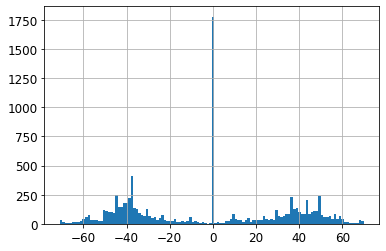

In [48]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=120)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


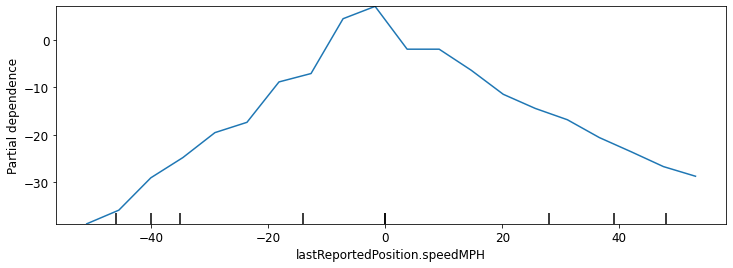

In [49]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [50]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [51]:
m = randomForest(xs, y);

In [52]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(4.944052, 10.46983)

In [53]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [54]:
r_mse(preds.mean(0), valid_y)

10.46983

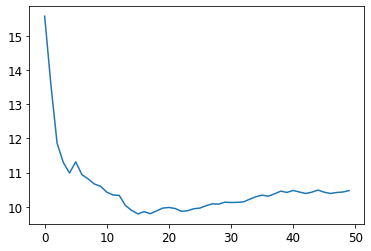

In [55]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [56]:
r_mse(m.oob_prediction_, y)

5.528723

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [57]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [58]:
preds.shape

(50, 893)

In [59]:
preds_std = preds.std(0)

In [60]:
preds_std[:5]

array([11.82870474,  9.68409361,  9.44099195, 10.96204927, 10.58014752])

# FEATURE Importance

In [61]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
33,lastReportedPosition.speedMPH,0.492076
51,lastReportedPosition.nextSignalState.signalState,0.047751
34,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.042176
24,lastReportedPosition.precedingSignalState.previousSignalState_na,0.040782
59,lastReportedPosition.positionTimeElapsed,0.039244
52,milepost,0.029851
29,loadedCarCount,0.025811
0,ptcLeadLocomotiveId,0.022594
40,aotuTrainData.totalLocomotiveWeight,0.021842
49,lastReportedPosition.precedingSignalState.signalState,0.019041


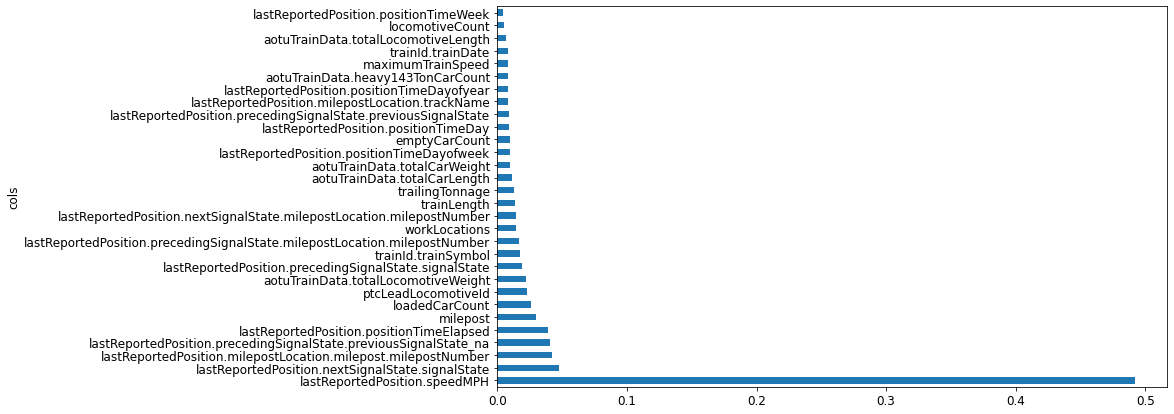

In [62]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [63]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

34

In [64]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [65]:
m = randomForest(xs_imp, y)

In [66]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(4.987427, 10.631529)

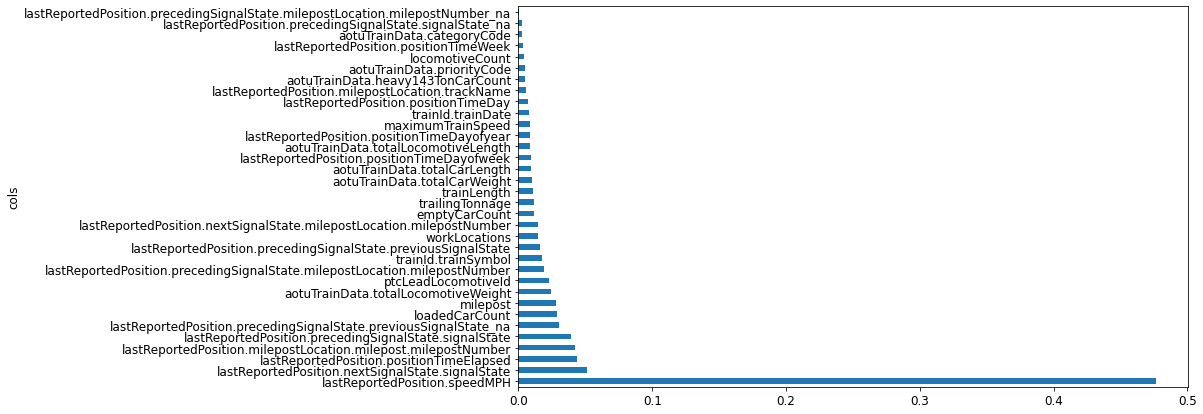

In [67]:
plot_fi(rf_feat_importance(m, xs_imp));

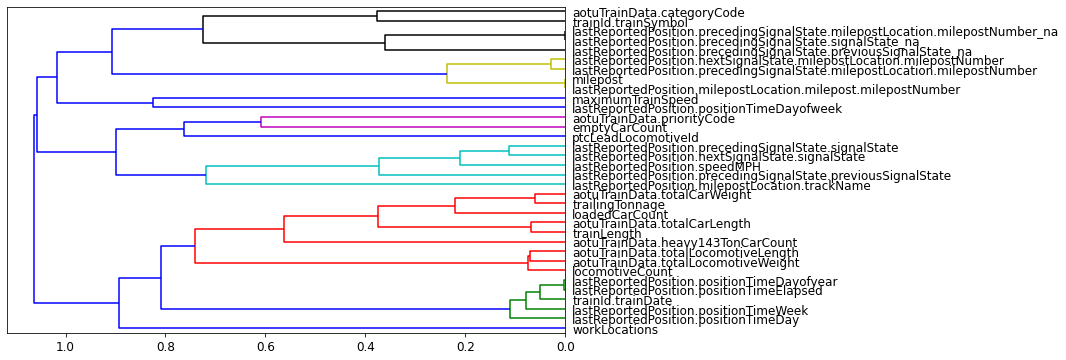

In [68]:
fastai.cluster_columns(xs_imp)